> In this notebook, otsus method will be compared with model 1 (broad institute model) and model 3 (10 different versions with 1 image left out of training for testing)
>
> The results will be evaluated visually and using IoU and F1 score

#### Imports

In [1]:
import sys
import os
import os.path

import numpy as np
import skimage.io
import glob

import shutil
#from config import config_vars

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import skimage.morphology

#import tensorflow as tf
#import keras

import utils.metrics
import utils.model_builder
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
import utils.evaluation

In [387]:
import seaborn as sb

#### Functions

In [433]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    #ax[3].imshow(IOU)
    #ax[3].set_title(image_name)

In [4]:
config_vars = {
    'object_dilation': 3
}

### Otsu's method (baseline) 

#### load images

###### ground truth

In [378]:
filename = sorted(os.listdir('/home/jupyter/cell-segmentation/aitslab_boundary_labels/resized_images/'))
image_names = [os.path.join('/home/jupyter/cell-segmentation/manually_annotated_images/all_images/', f) for f in filename]

gt_images = skimage.io.imread_collection(image_names)
gt_images = gt_images.concatenate()

###### otsus prediction

In [445]:
filename = sorted(os.listdir('/home/jupyter/cell-segmentation/aitslab_boundary_labels/resized_images/'))
image_names = [os.path.join('/home/jupyter/cell-segmentation/otsus_prediction/annotation/', f) for f in filename]

otsus_images = skimage.io.imread_collection(image_names)
otsus_images = otsus_images.concatenate()


#### Compare

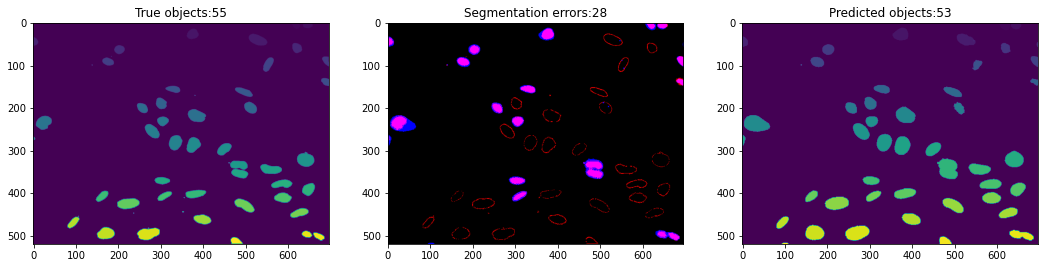

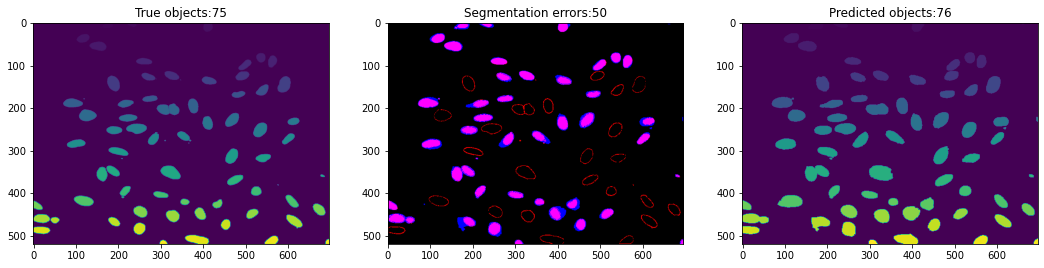

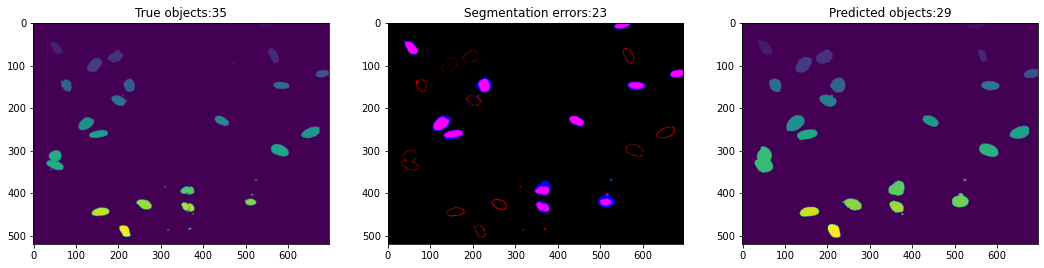

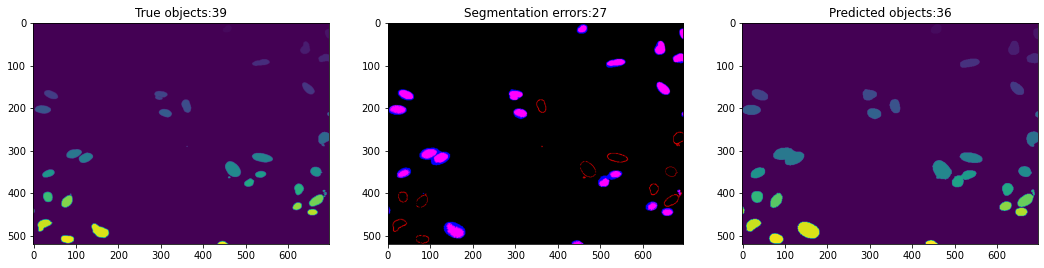

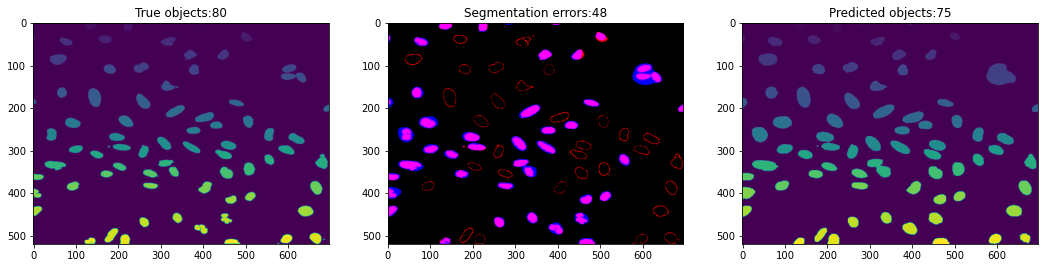

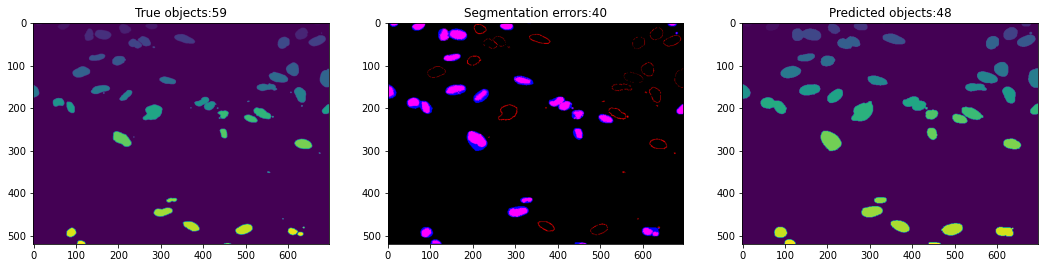

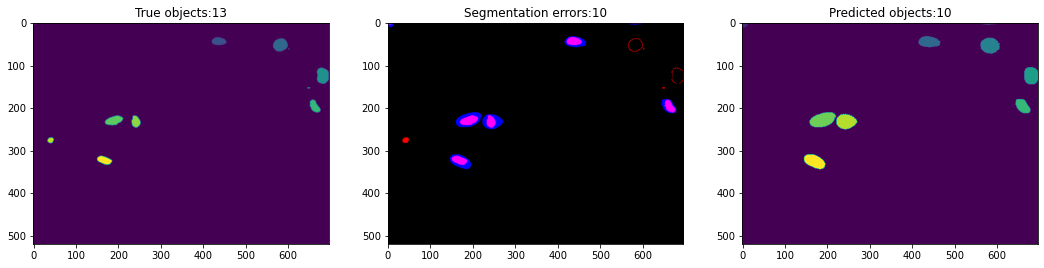

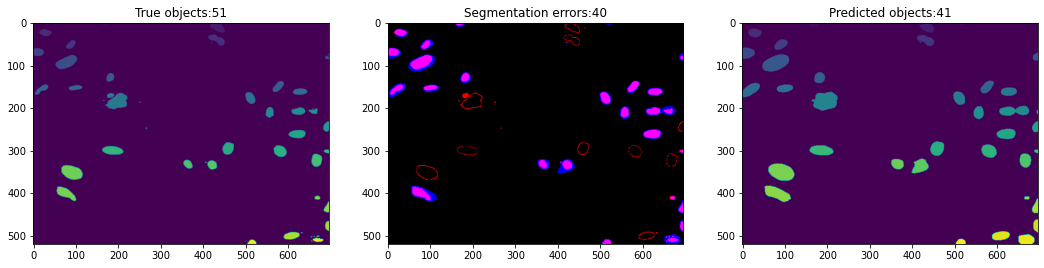

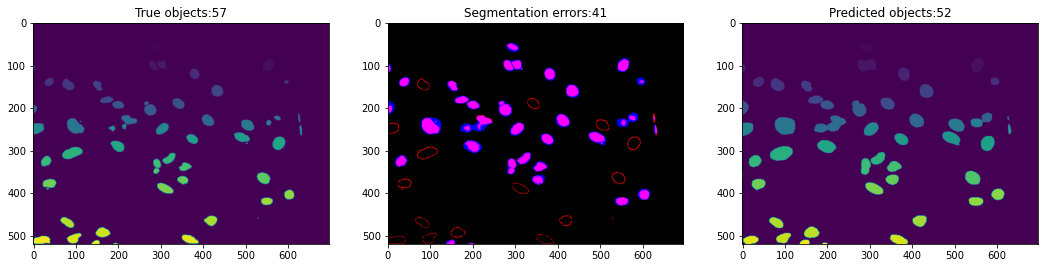

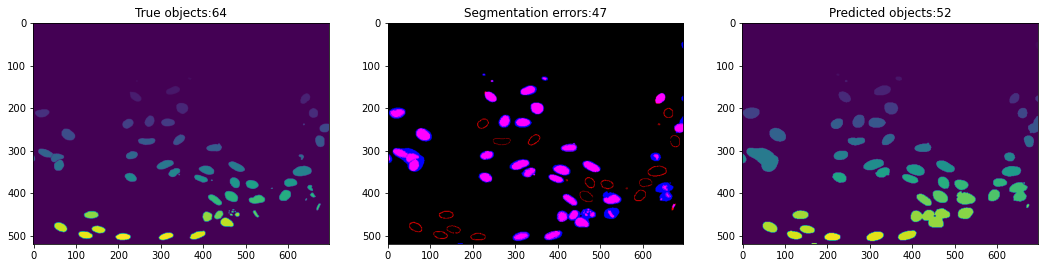

In [446]:
results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for n,i in enumerate(gt_images):
    # Load ground truth data
    #img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = i
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = ground_truth.astype(int)
    
    
    # Load predictions
    #pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    #prediction = skimage.io.imread(pred_filename)
    prediction = otsus_images[n]
    
    prediction = prediction.transpose()

    prediction = np.array([prediction,prediction,prediction])

    prediction = prediction.transpose()

    prediction = prediction[:,:,0]
    
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        filename[n]
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        filename[n]
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        filename[n]
    )
    show(ground_truth, prediction, image_name=filename[n])
    plt.savefig('/home/jupyter/cell-segmentation/evaluation/visual_comparison/otsus/' + filename[n][:-4] + '.svg', format='svg', dpi=1200)

    #plt.show()
    

    

'MFGTMPcx7_170803210001_J12f29d0.png'

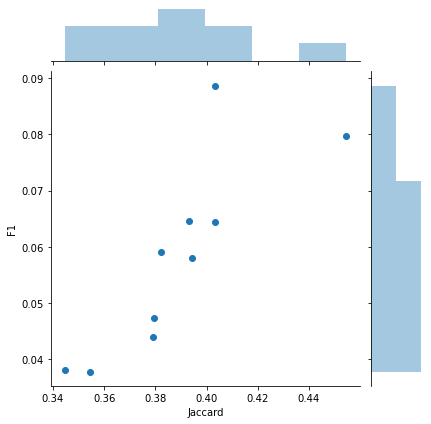

In [448]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R, x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False).loc[9, "Image"]
#g.savefig("otsus_f1_jacc.png")


,Threshold,F1,Jaccard
0,0.50,0.319078,0.388806
1,0.55,0.166235,0.388806
2,0.60,0.072665,0.388806
3,0.65,0.012134,0.388806
4,0.70,0.008143,0.388806
5,0.75,0.003176,0.388806
6,0.80,0.000000,0.388806
7,0.85,0.000000,0.388806
8,0.90,0.000000,0.388806
9,0.95,0.000000,0.388806


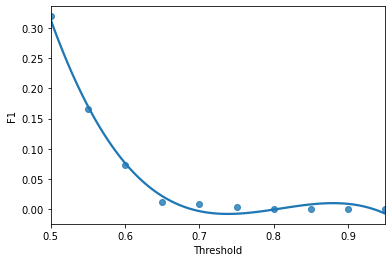

In [450]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance
#plt.savefig('otsus_f1_thresh.png')




In [403]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.05814320642462055
Jaccard index: 0.3888056516228246


In [404]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      133
Small nuclei     281
Normal nuclei     82
Large nuclei      17
Name: False_Negative, dtype: int64

In [405]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 457


#### up next

> let bbbc-model make predictions on images and evaluate
>
> let each och the model3 images make predictions on the image that the version hasnt been trained on and collect the results and evaluate

### BBBC-model (model 1)

##### load images

In [451]:
filename = sorted(os.listdir('/home/jupyter/cell-segmentation/aitslab_boundary_labels/resized_images/'))
image_names = [os.path.join('/home/jupyter/cell-segmentation/experiments/bbbc/out/segm/', f) for f in filename]

pred_images = skimage.io.imread_collection(image_names)
pred_images = pred_images.concatenate()


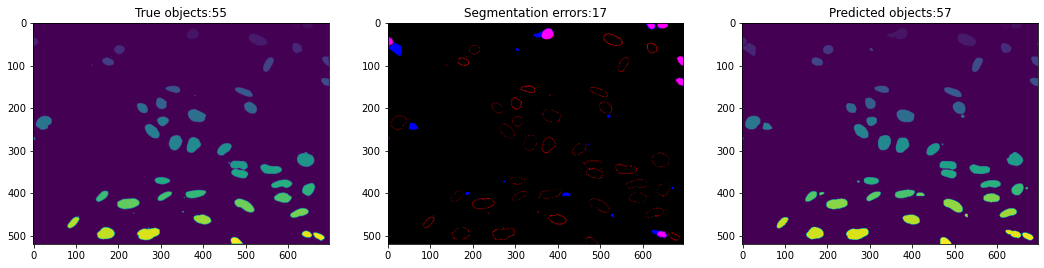

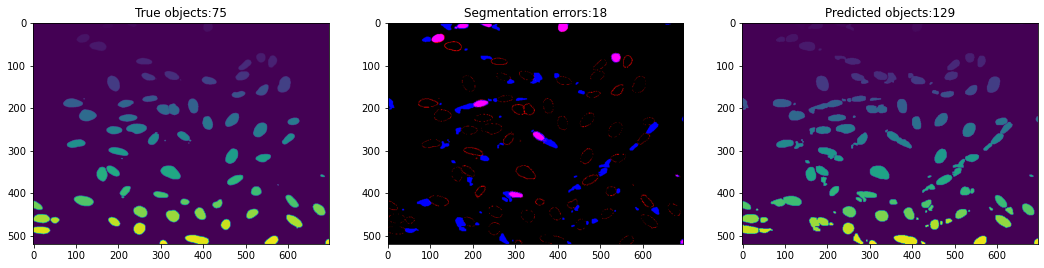

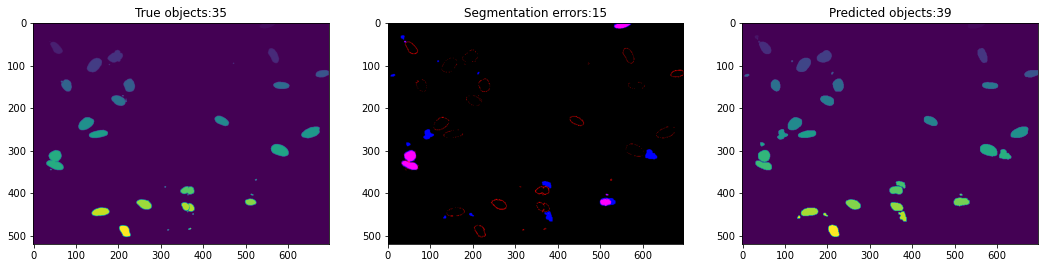

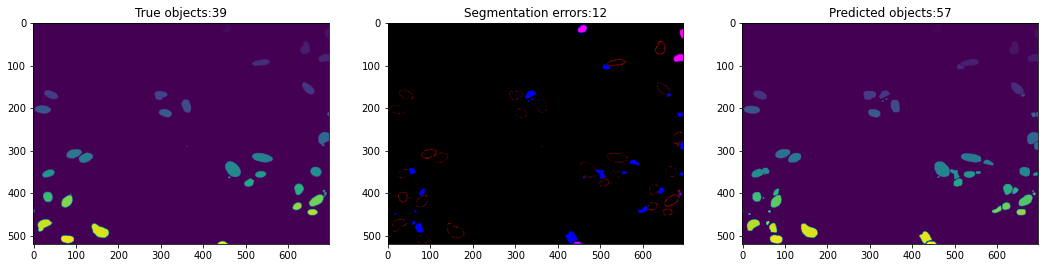

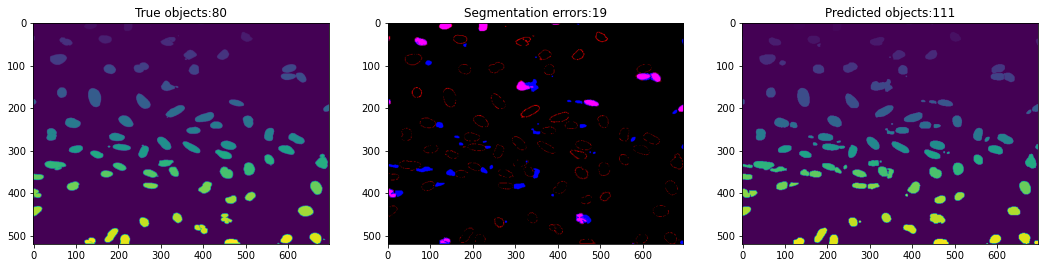

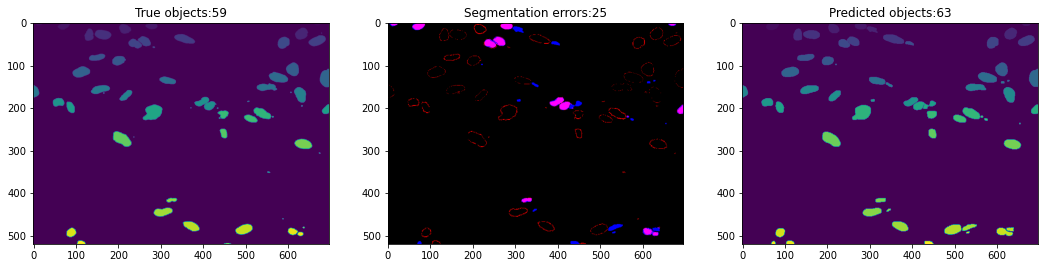

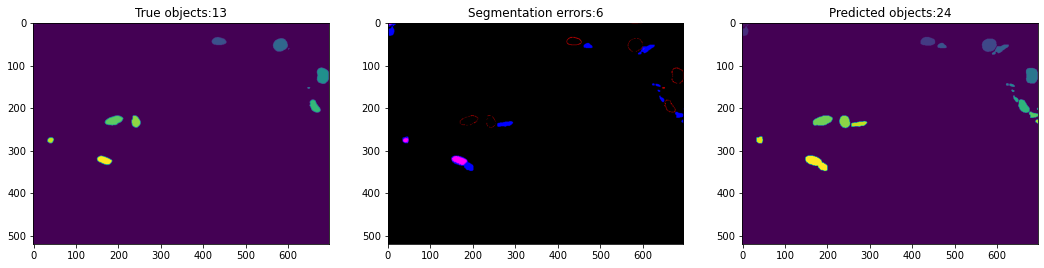

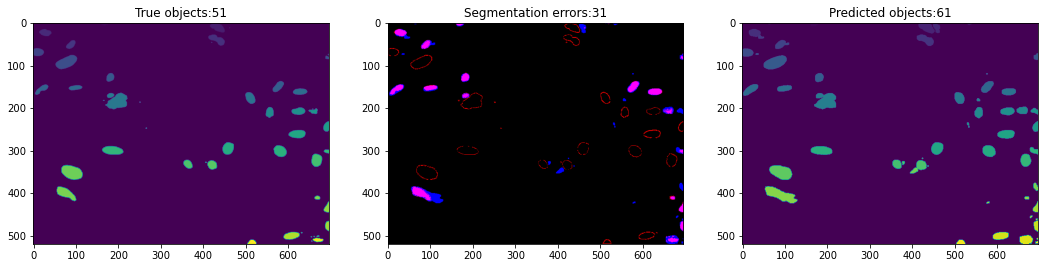

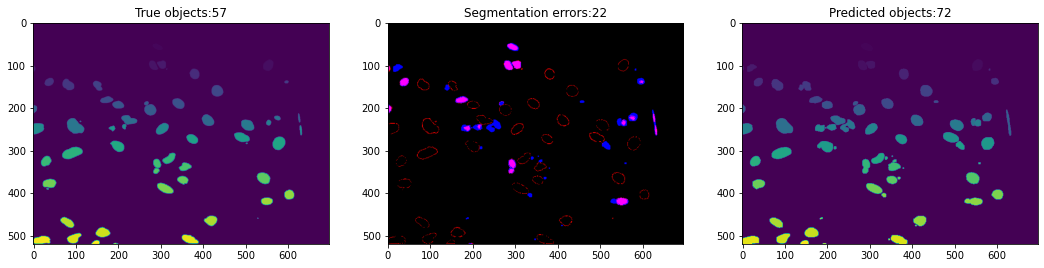

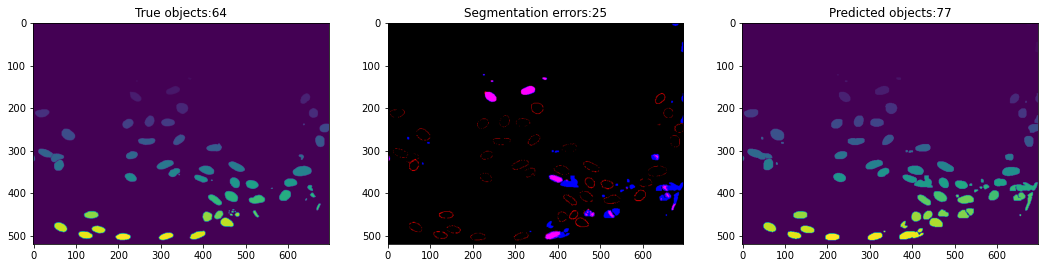

In [452]:
results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for n,i in enumerate(gt_images):
    # Load ground truth data
    #img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = i
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = ground_truth.astype(int)
    
    
    # Load predictions
    #pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    #prediction = skimage.io.imread(pred_filename)
    prediction = pred_images[n]
    
    #prediction = prediction.transpose()

    #prediction = np.array([prediction,prediction,prediction])

    #prediction = prediction.transpose()

    #prediction = prediction[:,:,0]
    
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        filename[n]
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        filename[n]
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        filename[n]
    )
    show(ground_truth, prediction, image_name=filename[n])
    plt.savefig('/home/jupyter/cell-segmentation/evaluation/visual_comparison/model1/' + filename[n][:-4] + '.svg', format='svg', dpi=1200)
    #plt.show()
    

    

'MFGTMPcx7_170803210001_J12f29d0.png'

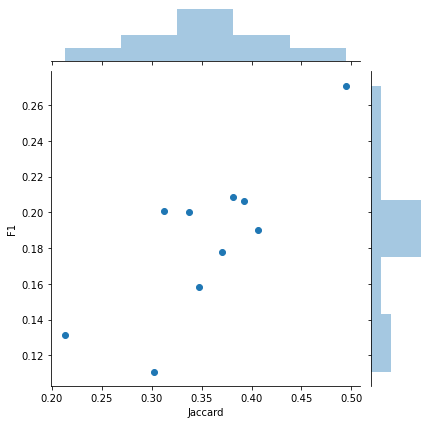

In [454]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R, x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False).loc[9, "Image"]
#g.savefig("m1_f1_jacc.png")


,Threshold,F1,Jaccard
0,0.50,0.523025,0.355597
1,0.55,0.489096,0.355597
2,0.60,0.362271,0.355597
3,0.65,0.260811,0.355597
4,0.70,0.152421,0.355597
5,0.75,0.052408,0.355597
6,0.80,0.015113,0.355597
7,0.85,0.000000,0.355597
8,0.90,0.000000,0.355597
9,0.95,0.000000,0.355597


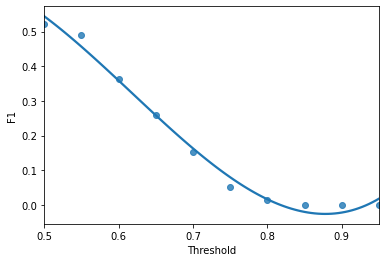

In [456]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance
#plt.savefig('m1_f1_thresh.png')

In [411]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.18551455291212118
Jaccard index: 0.35559740454643424


In [412]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      133
Small nuclei     241
Normal nuclei     48
Large nuclei       5
Name: False_Negative, dtype: int64

In [413]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 589


### Model 3

##### load images

In [421]:
filename = sorted(os.listdir('/home/jupyter/cell-segmentation/aitslab_boundary_labels/resized_images/'))

image_names = [os.path.join('/home/jupyter/cell-segmentation/experiments/model3_' + f[:-4] + '/out/segm/', f) for f in filename]

pred_images = skimage.io.imread_collection(image_names)
pred_images = pred_images.concatenate()


##### evaluate

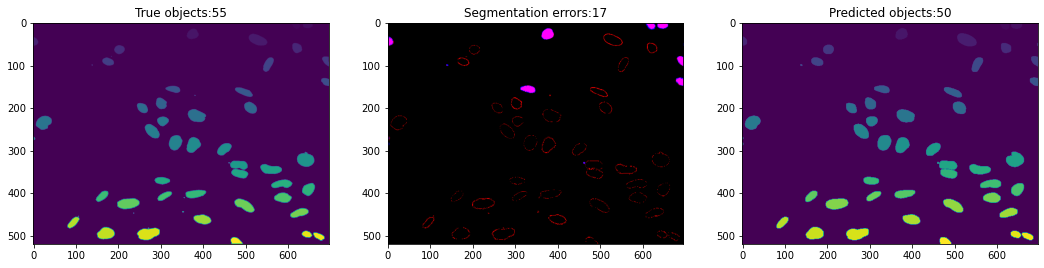

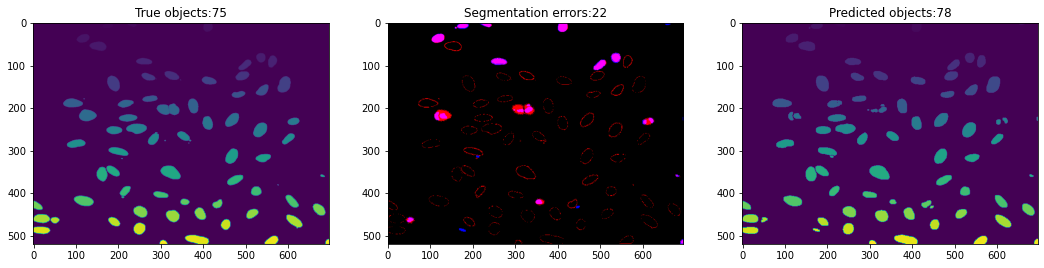

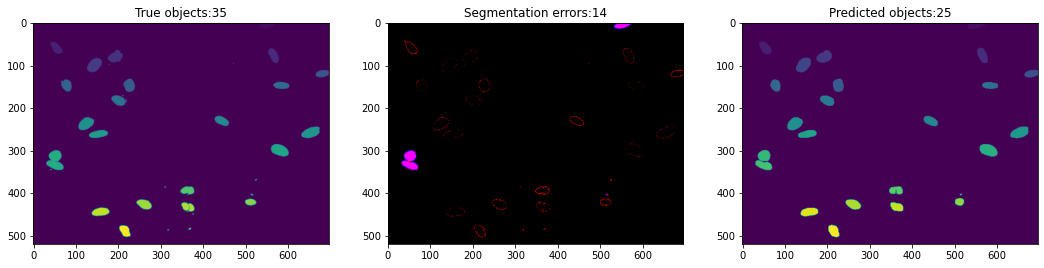

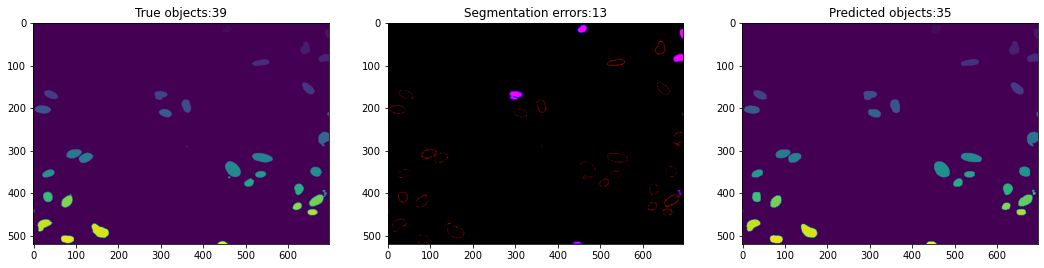

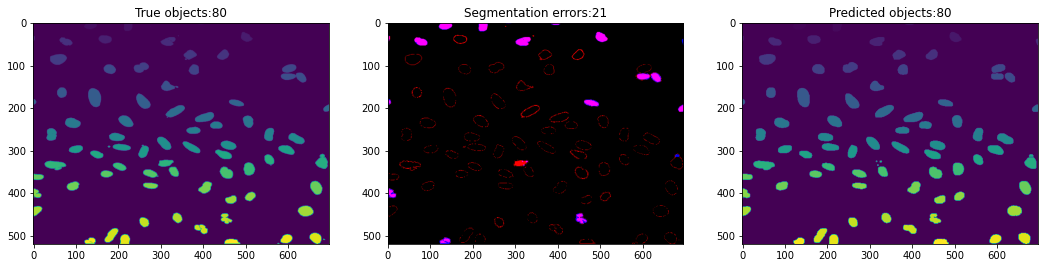

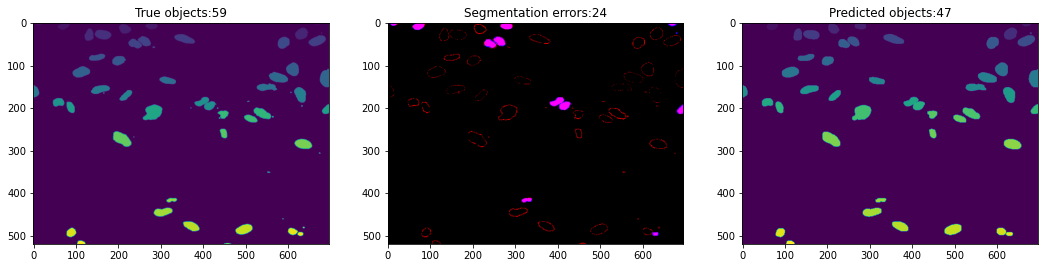

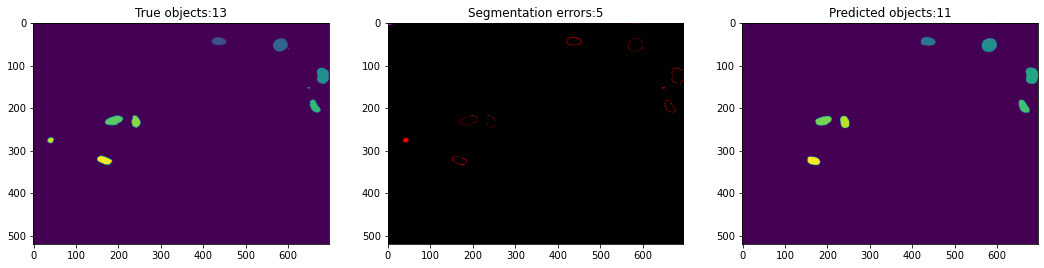

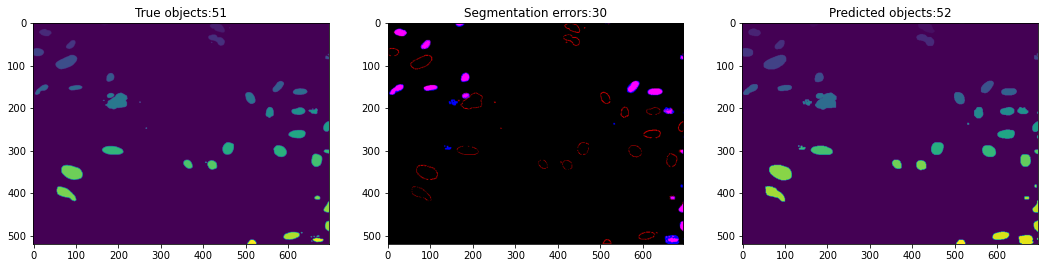

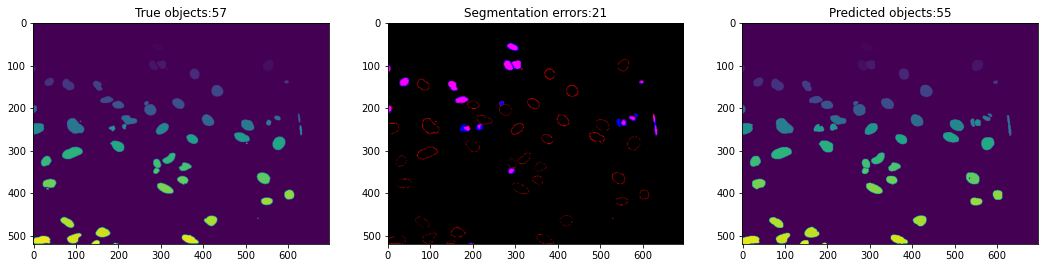

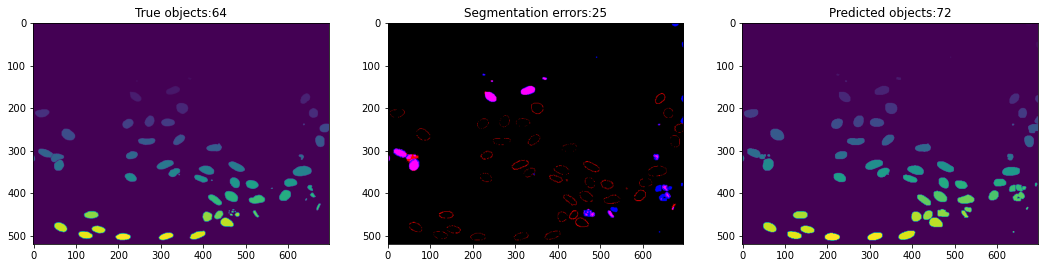

In [437]:
results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for n,i in enumerate(gt_images):
    # Load ground truth data
    #img_filename = os.path.join('/home/jupyter/aitslab_images/raw_annotations/', image_name)
    ground_truth = i
    ground_truth = skimage.morphology.label(ground_truth)
    ground_truth = resize(ground_truth, (520, 696), mode='constant', preserve_range=True)
    
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = ground_truth.astype(int)
    
    
    # Load predictions
    #pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    #prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    #prediction = skimage.io.imread(pred_filename)
    prediction = pred_images[n]
    
    #prediction = prediction.transpose()

    #prediction = np.array([prediction,prediction,prediction])

    #prediction = prediction.transpose()

    #prediction = prediction[:,:,0]
    
        
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        filename[n]
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        filename[n]
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        filename[n]
    )
    show(ground_truth, prediction, image_name=filename[n])
    plt.savefig('/home/jupyter/cell-segmentation/evaluation/visual_comparison/model3/' + filename[n][:-4] + '.svg', format='svg', dpi=1200)
    #plt.show()
    #break
    

    

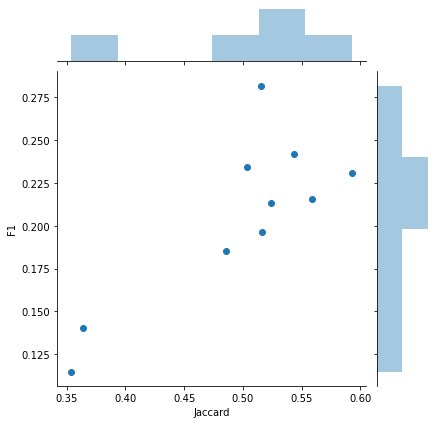

In [440]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R, x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False).loc[9, "Image"]
#g.savefig("m3_f1_jacc.png")

,Threshold,F1,Jaccard
0,0.50,0.639706,0.495756
1,0.55,0.558173,0.495756
2,0.60,0.420263,0.495756
3,0.65,0.269740,0.495756
4,0.70,0.133639,0.495756
5,0.75,0.025103,0.495756
6,0.80,0.008116,0.495756
7,0.85,0.000000,0.495756
8,0.90,0.000000,0.495756
9,0.95,0.000000,0.495756


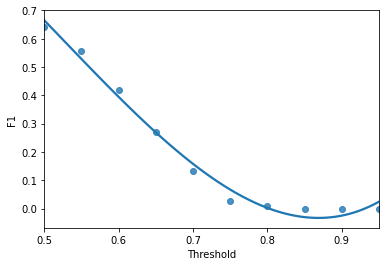

In [443]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance
#plt.savefig('m3_f1_thresh.png')


In [425]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.2054740335410866
Jaccard index: 0.49575596901098906


In [426]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      133
Small nuclei     261
Normal nuclei     61
Large nuclei       8
Name: False_Negative, dtype: int64

In [427]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 440
